## Lectura de los datos

#### Librerias

In [1]:
import pandas as pd
import numpy as np
import keras_metrics
import tensorflow as tf
import shutil, os, sys
import matplotlib.pyplot as plt



from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers, layers
from tensorflow.keras import utils as k
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory,image




#### Datos

In [2]:

file= 'metadata.csv'
dt=pd.read_csv(file, sep=",")

dt.head(1)

,patientid,offset,sex,age,finding,survival,intubated,intubation_present,went_icu,in_icu,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 28
0,2,0.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN


### Preprocesamiento

Vamos a ver en que proporcion encontramos las muestras de covid y las de otras enfermedades para que la red no se sobre entrene con un solo tipo de imagenes.

In [3]:
covid=[]
otro=[]

for i,r in dt.iterrows():
    if r['finding'] == 'COVID-19':
        covid.append(r)
    else:
        otro.append(r)

print("Co: ",len(covid) )
print("Otro: ",len(otro) )
print("Proporcion de Covid: ", len(covid)/(len(covid)+len(otro))*100)
    


Co:  296
Otro:  76
Proporcion de Covid:  79.56989247311827


Para que la funcion de keras: <i>image_dataset_from_directory</i> funcione para poder entrenar como queremos, separamos las fotos en dos capetas, una para covid y otra para el resto de enfermedades.

Como hemos visto hay muchas más radiografias de covid que de las otras enfermedades así que vamos a igualar el numero de muestras para cada clase.

##### Creamos los directorios

In [4]:
carpeta = os.getcwd()+os.sep+'images'


#SEPARACION EN LA CARPETA IMAGES
if not os.path.isdir(carpeta+os.sep+'covid') :
    os.mkdir(carpeta+os.sep+'covid')
if not os.path.isdir(carpeta+os.sep+'covid'+os.sep+'covid'):
    os.mkdir(carpeta+os.sep+'covid'+os.sep+'covid')
    
if not os.path.isdir(carpeta+os.sep+'otro') :
    os.mkdir(carpeta+os.sep+'otro')
if not os.path.isdir(carpeta+os.sep+'otro'+os.sep+'otro'):
    os.mkdir(carpeta+os.sep+'otro'+os.sep+'otro')
        
    
#SEPARACION EN LA CARPETA PARA EL TEST
if not os.path.isdir(os.getcwd()+os.sep+'test') :
    os.mkdir(os.getcwd()+os.sep+'test')
    if not os.path.isdir(os.getcwd()+os.sep+'test'+os.sep+'covid'):
        os.mkdir(os.getcwd()+os.sep+'test'+os.sep+'covid')
    if not os.path.isdir(os.getcwd()+os.sep+'test'+os.sep+'covid'+os.sep+'covid'):
        os.mkdir(os.getcwd()+os.sep+'test'+os.sep+'covid'+os.sep+'covid')
    if not os.path.isdir(os.getcwd()+os.sep+'test'+os.sep+'otro'):
        os.mkdir(os.getcwd()+os.sep+'test'+os.sep+'otro')
    if not os.path.isdir(os.getcwd()+os.sep+'test'+os.sep+'otro'+os.sep+'otro'):
        os.mkdir(os.getcwd()+os.sep+'test'+os.sep+'otro'+os.sep+'otro')

        
#SEPARACION EN LA CARPETA PARA LA VALIDACION
if not os.path.isdir(os.getcwd()+os.sep+'val') :
    os.mkdir(os.getcwd()+os.sep+'val')
    if not os.path.isdir(os.getcwd()+os.sep+'val'+os.sep+'covid'):
        os.mkdir(os.getcwd()+os.sep+'val'+os.sep+'covid')
    if not os.path.isdir(os.getcwd()+os.sep+'val'+os.sep+'covid'+os.sep+'covid'):
        os.mkdir(os.getcwd()+os.sep+'val'+os.sep+'covid'+os.sep+'covid')
    if not os.path.isdir(os.getcwd()+os.sep+'val'+os.sep+'otro'):
        os.mkdir(os.getcwd()+os.sep+'val'+os.sep+'otro')
    if not os.path.isdir(os.getcwd()+os.sep+'val'+os.sep+'otro'+os.sep+'otro'):
        os.mkdir(os.getcwd()+os.sep+'val'+os.sep+'otro'+os.sep+'otro')


#NUEVAS CARPETAS PARA ENTRENAMIENTO 
if not os.path.isdir(os.getcwd()+os.sep+'nuevas') :
    os.mkdir(os.getcwd()+os.sep+'nuevas')
    if not os.path.isdir(os.getcwd()+os.sep+'nuevas'+os.sep+'covid'):
        os.mkdir(os.getcwd()+os.sep+'nuevas'+os.sep+'covid')
        if not os.path.isdir(os.getcwd()+os.sep+'nuevas'+os.sep+'otro'):
            os.mkdir(os.getcwd()+os.sep+'nuevas'+os.sep+'otro')
            
            
#NUEVAS CARPETAS PARA TEST
if not os.path.isdir(os.getcwd()+os.sep+'nuevasT') :
    os.mkdir(os.getcwd()+os.sep+'nuevasT')
    if not os.path.isdir(os.getcwd()+os.sep+'nuevasT'+os.sep+'covid'):
        os.mkdir(os.getcwd()+os.sep+'nuevasT'+os.sep+'covid')
        if not os.path.isdir(os.getcwd()+os.sep+'nuevasT'+os.sep+'otro'):
            os.mkdir(os.getcwd()+os.sep+'nuevasT'+os.sep+'otro')
            
#NUEVAS CARPETAS PARA VALIDACION            
if not os.path.isdir(os.getcwd()+os.sep+'nuevasV') :
    os.mkdir(os.getcwd()+os.sep+'nuevasV')
    if not os.path.isdir(os.getcwd()+os.sep+'nuevasV'+os.sep+'covid'):
        os.mkdir(os.getcwd()+os.sep+'nuevasV'+os.sep+'covid')
        if not os.path.isdir(os.getcwd()+os.sep+'nuevasV'+os.sep+'otro'):
            os.mkdir(os.getcwd()+os.sep+'nuevasV'+os.sep+'otro')
            

In [5]:
dimensiones=[500,500]


##### Movemos las imagenes

In [6]:

foto=''
destino=''
ruta=carpeta+destino
noEstanco=[]
noEstanot=[]
NombresEntrenoCo=[]
NombresEntrenoOt=[]
NombresValCo=[]
NombresValOt=[]
NombresTestCo=[]
NombresTestOt=[]

numcovid=0  #flag para equilibrar las muestras
numValco=numTestco=0 #flag para coger muestras diferentes en test y prediccion covid
numValotro=numTestotro=0 #flag para coger muestras diferentes en test y `prediccion otra enfermedad
flag=0 #flag para no mover a las carpetas de images y que no aparezca en los dos directorios
pacienteAnteriorC=0
pacienteAnteriorO=0

fotosCo=0
fotosOt=0

for i,r in dt.iterrows():
    flag=0
    foto=r['filename']
    if r['finding'] == 'COVID-19': #si es covid
        if numcovid<(len(otro)-10):
            destino='covid'
            numcovid+=1
            
        elif numTestco < 6 and r['patientid'] != pacienteAnteriorC: #ejemplos de covid para test
            if os.path.exists(ruta+os.sep+foto):
                shutil.move(ruta+os.sep+foto,os.getcwd()+os.sep+'test'+os.sep+'covid'+os.sep+'covid')
                NombresTestCo.append(r['filename'])
                numTestco+=1
                flag=1
                noEstanco.append(foto)
        elif numValco < 8:
            if os.path.exists(ruta+os.sep+foto):
                shutil.move(ruta+os.sep+foto,os.getcwd()+os.sep+'val'+os.sep+'covid'+os.sep+'covid')
                NombresValCo.append(r['filename'])
                numValco+=1
    else: #Otra enfermedad
        if numTestotro < 6 and r['patientid'] != pacienteAnteriorO:#ejemplos de  otra enfermedad para prediccion
            if os.path.exists(ruta+os.sep+foto):
                shutil.move(ruta+os.sep+foto,os.getcwd()+os.sep+'test'+os.sep+'otro'+os.sep+'otro')
                NombresTestOt.append(r['filename'])
                numTestotro+=1
                flag=1
                noEstanot.append(foto)
                
        elif numValotro < 8: #movemos 8 imagenes de otra enfermedad para validacion
            if os.path.exists(ruta+os.sep+foto):
                shutil.move(ruta+os.sep+foto,os.getcwd()+os.sep+'val'+os.sep+'otro'+os.sep+'otro')
                NombresValOt.append(r['filename'])
                numValotro+=1
        destino='otro'
        
    if os.path.exists(ruta+os.sep+foto) and flag!=1:
        shutil.move(ruta+os.sep+foto,ruta+os.sep+destino+os.sep+destino)#+os.sep+destino
        #para aumentar los datos
        if destino=='covid':
            NombresEntrenoCo.append(r['filename'])
            fotosCo+=1
        else:
            fotosOt+=1
            NombresEntrenoOt.append(r['filename'])
    if r['finding'] == 'COVID-19':
        pacienteAnteriorC=r['patientid']
    else:
        pacienteAnteriorO=r['patientid']
    #print(ruta+os.sep+foto)
    

##### Aumentamos la caantidad de muestras que tenemos

In [7]:

aumento = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(dimensiones[0],dimensiones[1],3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)


nuevo=os.getcwd()+os.sep+'nuevas'
df=image.ImageDataGenerator(rotation_range=10, width_shift_range=0.08, height_shift_range=0.12,shear_range=0.12, zoom_range=0.08,channel_shift_range = 8, horizontal_flip=True)
#resul=image.DirectoryIterator(directory=carpeta, image_data_generator=df,target_size=(dimensiones[0],dimensiones[1]), color_mode='rgb', subset='training'
#                        class_mode='binary',batch_size=5)
#print(len(resul))
#imagen=df.flow_from_directory(carpeta, target_size=(dimensiones[0],dimensiones[1]), save_to_dir=nuevo, save_prefix='Nuevas', classes=['covid', 'otro'],class_mode="binary",batch_size=1, seed=1234)
#save_prefix='Nuevas',save_format='jpeg',


#ENTRENAMIENTO
cov=image.DirectoryIterator(directory=carpeta+os.sep+'covid',image_data_generator=df,target_size=(dimensiones[0],dimensiones[1]), color_mode='rgb',
                        class_mode=None,save_to_dir=nuevo+os.sep+'covid', save_prefix='Nuevas', batch_size=13,save_format='jpeg')
otr=image.DirectoryIterator(directory=carpeta+os.sep+'otro',image_data_generator=df,target_size=(dimensiones[0],dimensiones[1]), color_mode='rgb',
                        class_mode=None,save_to_dir=nuevo+os.sep+'otro', save_prefix='Nuevas', batch_size=20,save_format='jpeg')

#VALIDACION
covVal=image.DirectoryIterator(directory='val'+os.sep+'covid',image_data_generator=df,target_size=(dimensiones[0],dimensiones[1]), color_mode='rgb',
                        class_mode=None,save_to_dir='nuevasV'+os.sep+'covid', save_prefix='Nuevas', batch_size=17,save_format='jpeg')
otrVal=image.DirectoryIterator(directory='val'+os.sep+'otro',image_data_generator=df,target_size=(dimensiones[0],dimensiones[1]), color_mode='rgb',
                        class_mode=None,save_to_dir='nuevasV'+os.sep+'otro', save_prefix='Nuevas', batch_size=17,save_format='jpeg')

#TEST
Tco=image.DirectoryIterator(directory='test'+os.sep+'covid',image_data_generator=df,target_size=(dimensiones[0],dimensiones[1]), color_mode='rgb',
                        class_mode=None,save_to_dir='nuevasT'+os.sep+'covid', save_prefix='Nuevas', batch_size=10,save_format='jpeg')
Tot=image.DirectoryIterator(directory='test'+os.sep+'otro',image_data_generator=df,target_size=(dimensiones[0],dimensiones[1]), color_mode='rgb',
                        class_mode=None,save_to_dir='nuevasT'+os.sep+'otro', save_prefix='Nuevas', batch_size=10,save_format='jpeg')


#imagen.next()
#entreno=df.fit(imagen, rounds=4)


#l=[]
#for j in range(len(NombresEntrenoCo)):
#    for i in range(9):
#        #carpeta+os.sep+'covid'+os.sep+NombresEntrenoCo[j]
#        imagen=image.load_img(carpeta+os.sep+'covid'+os.sep+NombresEntrenoCo[j], grayscale=False, color_mode='rgb', target_size=(dimensiones[0],dimensiones[1]))
#        imagen=image.img_to_array(imagen)
#        imagen=np.array([imagen])
#        df.flow(imagen,batch_size=5, save_to_dir=os.getcwd()+os.sep+"jk", save_format='jpg',shuffle=True,save_prefix='Nuevas')
        #nueva = aumento(imagen)
        #cv2.imwrite(carpeta+os.sep+"covid",nueva[0].numpy().astype("uint8"))

#for j in range(len(NombresEntrenoOt)):
#    
#    imagen=image.load_img(carpeta+os.sep+'otro'+os.sep+'otro'+os.sep+NombresEntrenoCo[j], grayscale=False, color_mode='rgb', target_size=(dimensiones[0],dimensiones[1]))
#    imagen=image.img_to_array(imagen)
#    imagen=np.array(imagen)
#    imagen.next()
#    #image = np.expand_dims(ndimage.imread(carpeta+os.sep+'otro'+os.sep+'otro'+os.sep+NombresEntrenoCo[j]), 0)
#    df.fit(imagen)
#    for x, val in zip(df.flow(imagen,save_to_dir=os.getcwd()+os.sep+"nuevas"+os.sep+"covid",save_prefix='Nueva',save_format='jpeg'),range(5)):
#        pass
    #df.flow(imagen,batch_size=3, save_to_dir=carpeta+os.sep+'otro', save_format='jpg',shuffle=True)


#df.fit(image)

pd= layers.ZeroPadding2D(padding=2)

Found 75 images belonging to 1 classes.
Found 62 images belonging to 1 classes.
Found 8 images belonging to 1 classes.
Found 8 images belonging to 1 classes.
Found 6 images belonging to 1 classes.
Found 6 images belonging to 1 classes.


In [8]:
print(len(cov))
print(len(otr))
print(len(covVal))
print(len(otrVal))

for j in range(40):
    for i in range(len(cov)):
        cov.next()
    for i in range(len(otr)):
        otr.next()
        


6
4
1
1


In [9]:
for g in range(50):
    for i in range(len(covVal)):
        covVal.next()
    for i in range(len(otrVal)):
        otrVal.next()

##### Movemos las imagenes originales

In [8]:
#ENTRENAMIENTO
for i in range(len(NombresEntrenoCo)):
    if os.path.exists(ruta+os.sep+'covid'+os.sep+'covid'+os.sep+NombresEntrenoCo[i]):
        shutil.move(ruta+os.sep+'covid'+os.sep+'covid'+os.sep+NombresEntrenoCo[i],'nuevas'+os.sep+'covid')
for i in range(len(NombresEntrenoOt)):
    if os.path.exists(ruta+os.sep+'otro'+os.sep+'otro'+os.sep+NombresEntrenoOt[i]):
        shutil.move(ruta+os.sep+'otro'+os.sep+'otro'+os.sep+NombresEntrenoOt[i],'nuevas'+os.sep+'otro')
#VALIDACION       
for i in range(len(NombresValCo)):
    if os.path.exists('val'+os.sep+'covid'+os.sep+'covid'+os.sep+NombresValCo[i]):
        shutil.move('val'+os.sep+'covid'+os.sep+'covid'+os.sep+NombresValCo[i],'nuevasV'+os.sep+'covid')
for i in range(len(NombresValOt)):
    if os.path.exists('val'+os.sep+'otro'+os.sep+'otro'+os.sep+NombresValOt[i]):
        shutil.move('val'+os.sep+'otro'+os.sep+'otro'+os.sep+NombresValOt[i],'nuevasV'+os.sep+'otro')


##### Guardamos las imagenes en memoria

In [9]:

#entreno, val, test=image_dataset_from_directory(directory="images", image_size=(dimensiones[0],dimensiones[1]), subset="training", validation_split=0.2, seed=1234,
#                                      labels='inferred')



#entrenamiento
img_fit= image_dataset_from_directory(directory=nuevo, image_size=(dimensiones[0],dimensiones[1]), seed=764,
                                      labels='inferred',shuffle=True)


clases=img_fit.class_names

#validadcion
img_val=image_dataset_from_directory(directory='nuevasV', image_size=(dimensiones[0],dimensiones[1]), seed=9876,
                                      labels='inferred',shuffle=True)
#clases=img_val.class_names




#PARA MEJORAR EL RENDIMIENTO
AUTOTUNE = tf.data.AUTOTUNE
img_fit=img_fit.cache().prefetch(buffer_size=AUTOTUNE)
img_val=img_val.cache().prefetch(buffer_size=AUTOTUNE)

Normalizar= layers.experimental.preprocessing.Rescaling(1./255, input_shape=(dimensiones[0],dimensiones[1], 3))


Found 5617 files belonging to 2 classes.
Found 816 files belonging to 2 classes.


### CREACION DEL MODELO

In [10]:
pool= 5 #CON UN POOL MÁS GRANDE SE REDUCEN LOS PESOS
pd= layers.ZeroPadding2D(padding=2) #PADDING
model= Sequential([
    #aumento,
    Normalizar,
    pd,
    layers.Conv2D(filters=16,kernel_size=3,padding='same',activation='relu', strides=1),
    layers.MaxPooling2D(pool_size=pool),
    #layers.Dropout(0.05),
    layers.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu', strides=1),
    layers.MaxPooling2D(pool_size=pool),
    pd,
    #layers.Dropout(0.05),
    layers.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu', strides=1),
    layers.MaxPooling2D(pool_size=pool),
    pd,
    layers.Conv2D(filters=128,kernel_size=3,padding='same',activation='relu', strides=1),
    #pd,
    #layers.Conv2D(filters=256,kernel_size=5,padding='same',activation='relu', strides=1),
    #layers.MaxPooling2D(pool_size=pool),
    ##pd,
    #layers.Conv2D(filters=512,kernel_size=5,padding='same',activation='relu', strides=1),
    #layers.MaxPooling2D(pool_size=pool),
    layers.Dropout(0.5),
    layers.Flatten(),
    Dense(100,'relu'),
    #Dense(1000,'relu'),
    Dense(1,'sigmoid')

])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 500, 500, 3)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin multiple                  0         
_________________________________________________________________
conv2d (Conv2D)              (None, 504, 504, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)       

### ENTRENAMIENTO

In [ ]:
opti= optimizers.Adam(learning_rate=0.3)#learning_rate=0.05,epsilon=0.8
vueltas=15

model.compile(optimizer=opti, loss='binary_crossentropy', metrics=['accuracy'])
historico=model.fit(img_fit, validation_data= img_val,batch_size=64 ,epochs= vueltas,shuffle=True)

Epoch 1/15
176/176 [==============================] - 325s 2s/step - loss: 8.6746 - accuracy: 0.5045 - val_loss: 0.7070 - val_accuracy: 0.5000
Epoch 2/15
176/176 [==============================] - 322s 2s/step - loss: 0.6958 - accuracy: 0.5338 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 3/15
176/176 [==============================] - 322s 2s/step - loss: 0.6892 - accuracy: 0.5572 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/15
176/176 [==============================] - 322s 2s/step - loss: 0.6902 - accuracy: 0.5428 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/15
176/176 [==============================] - 324s 2s/step - loss: 0.6908 - accuracy: 0.5324 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 6/15
176/176 [==============================] - 324s 2s/step - loss: 0.6913 - accuracy: 0.5272 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 7/15
176/176 [==============================] - 323s 2s/step - loss: 0.6916 - accuracy: 0.5289 - val_loss: 0.6936 - val_accuracy: 0.5000

##### RESULTADOS DEL ENTRENAMIENTO SIN DATA AUGMENTATION

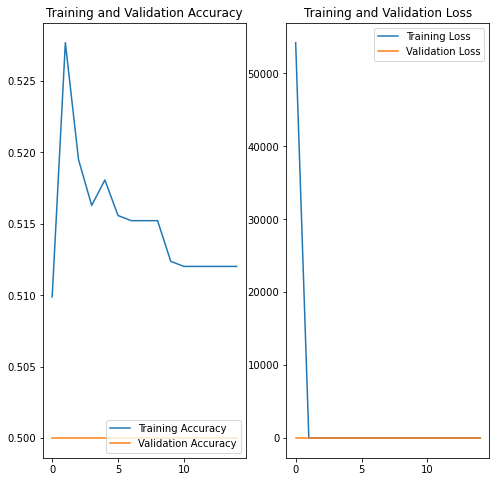

In [16]:


acc = historico.history['accuracy']
val_acc = historico.history['val_accuracy']

loss = historico.history['loss']
val_loss = historico.history['val_loss']

epochs_range = range(vueltas)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
#Con los datos aumentados

#historicoNu=model.fit(resul, validation_data= img_val, epochs=vueltas)

##### RESULTADOS DEL ENTRENAMIENTO CON LAS NUEVAS IMAGENES

In [16]:

for j in range(10):
    for i in range(len(Tco)):
        Tco.next()
    for i in range(len(Tot)):
        Tot.next()
        


In [17]:
#TEST
for i in range(len(NombresTestCo)):
    if os.path.exists('test'+os.sep+'covid'+os.sep+'covid'+os.sep+NombresTestCo[i]):
        shutil.move('test'+os.sep+'covid'+os.sep+'covid'+os.sep+NombresTestCo[i],'nuevasT'+os.sep+'covid')
for i in range(len(NombresTestOt)):
    if os.path.exists('test'+os.sep+'otro'+os.sep+'otro'+os.sep+NombresTestOt[i]):
        shutil.move('test'+os.sep+'otro'+os.sep+'otro'+os.sep+NombresTestOt[i],'nuevasT'+os.sep+'otro')

Error: Destination path 'nuevasT\covid\7AF6C1AF-D249-4BD2-8C26-449304105D03.jpeg' already exists

In [18]:


img=image_dataset_from_directory(directory="nuevasT", image_size=(dimensiones[0],dimensiones[1]), 
                                      labels='inferred')


tf.nn.sigmoid(model.predict(img))

Found 132 files belonging to 2 classes.


<tf.Tensor: shape=(132, 1), dtype=float32, numpy=
array([[0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.6331676],
       [0.

In [19]:
test_loss, test_acc = model.evaluate(img)


5/5 [==============================] - 2s 352ms/step - loss: 0.6974 - accuracy: 0.5000
